This notebook is meant to **showcase the library’s functionality**. It includes key snippets from both `src/` (the source code) and `./demo.ipynb` (the usage demo) to help explain the overall structure.

To run this notebook (or `demo.ipynb`), you’ll need **Jupyter** and **matplotlib** installed. These are not included in `requirements.txt` since that file only contains dependencies for the core library (`src/`).

In [1]:
# Import the library from src

import os
import sys
from pathlib import Path
base_dir = Path(os.getcwd()).resolve().parent
sys.path.append(str(base_dir))

import src
from src import nn
from src import optim
from src.nn import functional as F

In [2]:
# Load dataset and prep it (kinda)

import numpy as np
from typing import Literal

# Load from dir (using numpy, i was done with the demo code before pandas was 'allowed'...)
train_data = np.loadtxt("./data/train.csv", delimiter=",", skiprows=1)
test_data = np.loadtxt("./data/test.csv", delimiter=",", skiprows=1)
print(f"train: {train_data.shape} | test: {test_data.shape}")

# Normalize
X_train = train_data[:, 1:] / 255.
y_train = train_data[:, 0].astype(int)
X_test = test_data[:, 1:] / 255.
y_test = test_data[:, 0].astype(int)
print(f"normalized data-splits")

class Dataset:
    def __init__(self, split: Literal["train", "test"], batch_size: int = 1):
        self.X_split = X_train if split == "train" else X_test
        self.y_split = y_train if split == "train" else y_test
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.y_split) / self.batch_size))

    def __getitem__(self, idx: int):
        start = idx * self.batch_size
        end = min((idx + 1) * self.batch_size, len(self.y_split))

        batch_X = self.X_split[start:end]
        batch_y = self.y_split[start:end]

        return src.Tensor(batch_X), src.Tensor(batch_y)  # Targets can stay as np.ndarray for now
    
train_dataset = Dataset(split="train")
test_dataset = Dataset(split="test")
print(f"train_dataset: {len(train_dataset)} | test_dataset: {len(test_dataset)}")

X, y = train_dataset[np.random.randint(low=0, high=len(train_dataset))]
print(f"Get random samples | X: {X.shape} | y: {y}")

train: (60000, 785) | test: (10000, 785)
normalized data-splits
train_dataset: 60000 | test_dataset: 10000
Get random samples | X: (1, 784) | y: tensor([4], requires_grad=False)


In [3]:
# training a model

epochs = 5
batch_size = 32  # batch the dataset(s)
train_dataset = Dataset(split="train", batch_size=batch_size)
test_dataset = Dataset(split="test", batch_size=batch_size)
print("---"*5)
print(f"[INFO] Datasets created with batch_size: {batch_size}")

# setup some acc-fn for accuracy tracking over epochs
def accuracy_fn(logits, targets):
    if isinstance(targets, src.Tensor):
        targets = targets.data
    preds = np.argmax(logits.data, axis=-1)
    return (preds == targets).astype(np.float32).mean()

# define a partial model
model = nn.Sequential(
    nn.Linear(784, 128, bias=True),
    nn.ReLU(),
    nn.Linear(128, 64, bias=True),
    nn.ReLU(),
)
# use `.add()` to 'add' the final layer
model.add(nn.Linear(64, 10, bias=True))
print("---"*5)
print(f"[INFO] Model created, final layer added too")

# setup optimizer and results-dict for model tracking
optimizer = optim.SGD(params=model.parameters(), lr=1e-1)  # testing with: [1e-1, 1e-2, 1e-3] and 1e-1 is fastest... (lr=0.1)
results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": [],
}

print("---"*5)
print(f"[INFO] Training begins")
# train the model (similar to torch)
for epoch in range(epochs):
    # train-step
    train_loss = 0.0
    train_acc = 0.0
    indices = np.random.permutation(len(train_dataset))
    for i in indices:
        X, y = train_dataset[i]
        logits = model(X)
        loss = F.cross_entropy_loss(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.data
        train_acc += accuracy_fn(logits, y)
    
    # test-step
    test_loss = 0.0
    test_acc = 0.0
    indices = np.random.permutation(len(test_dataset))
    for i in indices:
        X, y = train_dataset[i]
        logits = model(X)
        loss = F.cross_entropy_loss(logits, y)
        
        test_loss += loss.data
        test_acc += accuracy_fn(logits, y)
    
    train_loss /= len(train_dataset)
    train_acc /= len(train_dataset)
    test_loss /= len(test_dataset)
    test_acc /= len(test_dataset)

    results["train_loss"].append(float(train_loss))
    results["train_acc"].append(float(train_acc))
    results["test_loss"].append(float(test_loss))
    results["test_acc"].append(float(test_acc))
    
    print(f"Epoch {epoch+1}/{epochs} | train_loss: {train_loss:.4f} | train_acc: {train_acc*100:.2f}% | test_loss: {test_loss:.4f} | test_acc: {test_acc*100:.2f}%")

print("---"*5)
print(f"[INFO] Training complete")

---------------
[INFO] Datasets created with batch_size: 32
---------------
[INFO] Model created, final layer added too
---------------
[INFO] Training begins
Epoch 1/5 | train_loss: 0.3032 | train_acc: 90.92% | test_loss: 0.1377 | test_acc: 95.92%
Epoch 2/5 | train_loss: 0.1223 | train_acc: 96.26% | test_loss: 0.0897 | test_acc: 97.25%
Epoch 3/5 | train_loss: 0.0859 | train_acc: 97.35% | test_loss: 0.0577 | test_acc: 98.26%
Epoch 4/5 | train_loss: 0.0664 | train_acc: 97.99% | test_loss: 0.0481 | test_acc: 98.65%
Epoch 5/5 | train_loss: 0.0527 | train_acc: 98.34% | test_loss: 0.0393 | test_acc: 98.88%
---------------
[INFO] Training complete


In [4]:
results

{'train_loss': [0.30319875889125486,
  0.12231285589697007,
  0.08592890866716495,
  0.06635138543528948,
  0.052731734540299204],
 'train_acc': [0.909166693687439,
  0.9625833630561829,
  0.9735333323478699,
  0.9798499941825867,
  0.9833833575248718],
 'test_loss': [0.13774474514504173,
  0.08968221091118495,
  0.05771116883627994,
  0.04810834480835544,
  0.03934161325898776],
 'test_acc': [0.9591653347015381,
  0.9725439548492432,
  0.982627809047699,
  0.9865215420722961,
  0.9888178706169128]}

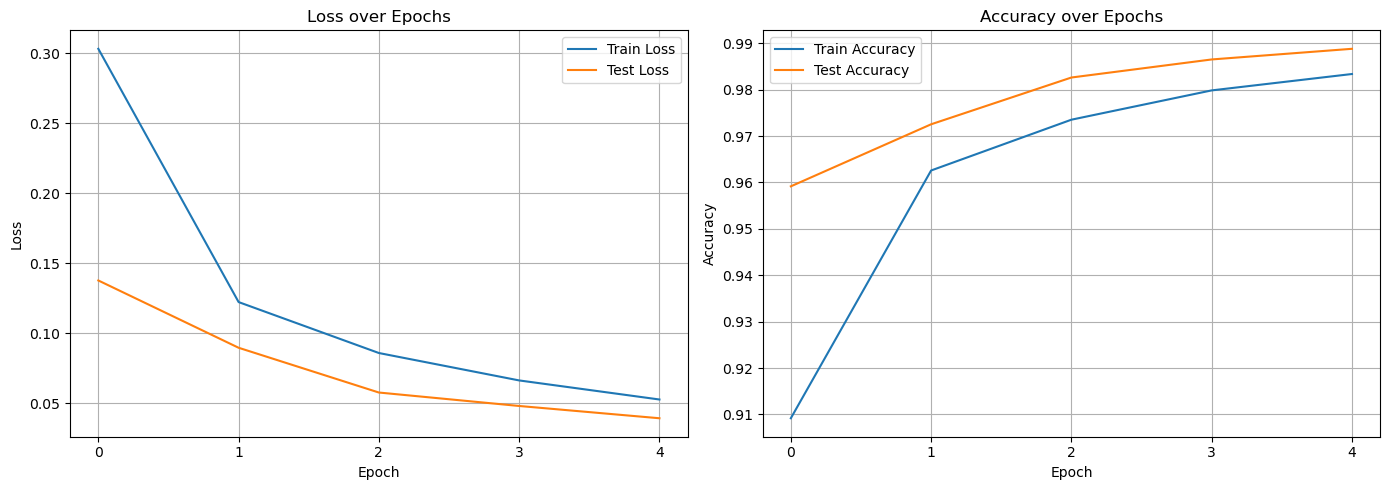

In [5]:
# Compare train/test loss and acc

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# loss
axes[0].plot(results["train_loss"], label="Train Loss")
axes[0].plot(results["test_loss"], label="Test Loss")
axes[0].set_title("Loss over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))

# acc
axes[1].plot(results["train_acc"], label="Train Accuracy")
axes[1].plot(results["test_acc"], label="Test Accuracy")
axes[1].set_title("Accuracy over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True)
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()
